# Random Forest – Predictive Analytics for Customer Retention

## Overview


This notebook provides a comprehensive end-to-end workflow for building a Random Forest classification model to predict customer churn. Churn—the rate at which customers stop doing business with an entity—is a critical metric for any subscription-based or service-oriented business.

**Random Forest**

The Random Forest algorithm is an "ensemble" method that constructs a multitude of decision trees during training. It is particularly effective for churn analysis because:

- Non-Linearity: It naturally captures complex relationships between features (e.g., how the impact of "Monthly Charges" might change based on "Tenure").

- Robustness: By averaging the results of many trees, it resists overfitting and handles "noisy" data better than a single decision tree.

- Interpretability: It provides built-in feature importance scores, allowing us to see exactly which factors—such as contract type or payment method—are driving customers away.

**Analysis Roadmap**

To answer the core question—"Can we accurately predict customer churn based solely on customer attributes?"—we will follow a structured data science pipeline:

- Data Acquisition & Inspection: Loading the customer dataset and performing exploratory data analysis (EDA) to understand target distribution and identify data quality issues (like the common TotalCharges formatting bug).

- Advanced Preprocessing: Utilizing ColumnTransformer and Pipelines to handle disparate data types—scaling numeric values for stability and one-hot encoding categorical variables for model compatibility.

- Experimental Design: Splitting data into stratified training and test sets to ensure that the minority "Churn" class is represented proportionally in both stages.

- Hyperparameter Optimization: Implementing GridSearchCV to systematically test combinations of tree depth and estimator counts, ensuring we find the "sweet spot" between bias and variance.

- Multi-Metric Evaluation: Moving beyond simple accuracy to evaluate the model through Precision-Recall, Confusion Matrices, and ROC/AUC curves to understand the trade-offs in predicting churn.

- Explainable AI (XAI): Visualizing feature importances and utilizing SHAP (SHapley Additive exPlanations) to transform the "black box" model into a transparent tool that provides a personalized "churn story" for every customer.

By the end of this notebook, you will have a production-ready pipeline that not only identifies who is likely to leave but explains why, empowering a business to take proactive, data-driven retention actions.

In [ ]:
# Comment out if not required 
# %pip install pandas numpy matplotlib seaborn scikit-learn ipywidgets


Shape: (7043, 20)

Target distribution:
 Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best CV F1-Score: 0.634
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1552
           1       0.56      0.75      0.64       561

    accuracy                           0.77      2113
   macro avg       0.73      0.77      0.74      2113
weighted avg       0.81      0.77      0.78      2113



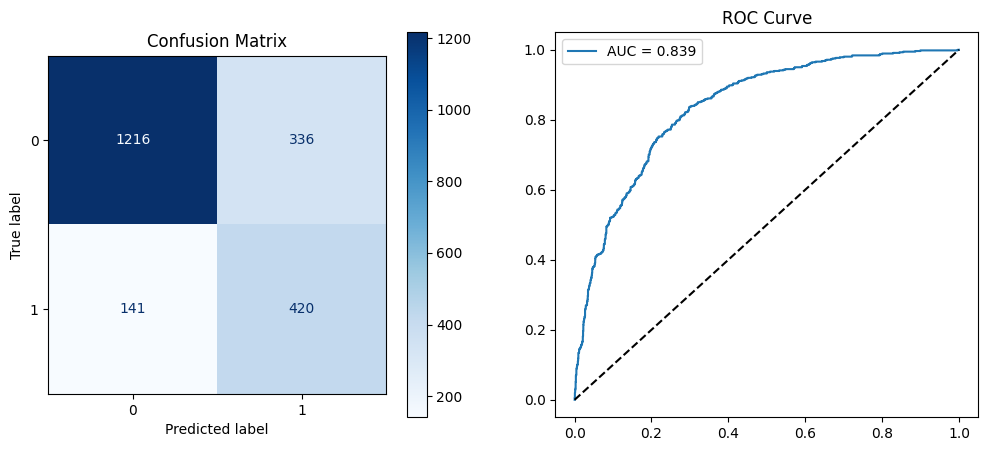

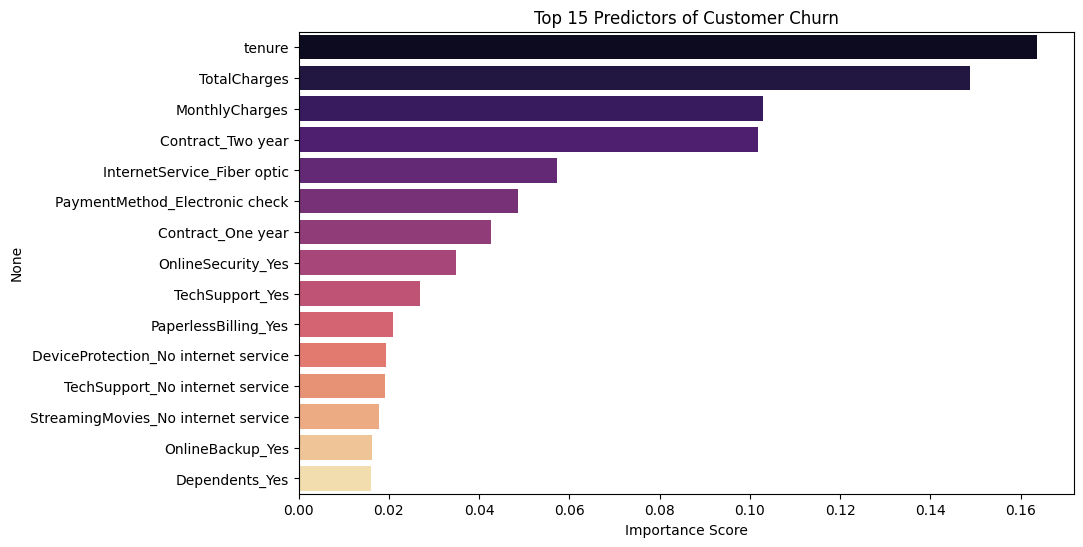

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)


# 1. Load & Inspect Data

df = pd.read_csv('Data/Customer-Churn.csv')

# --- FIX: Handle potential numeric conversion issues ---
# TotalCharges often has hidden empty strings that make it an 'object' type
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(0) 

# Drop CustomerID if it exists - it has no predictive power
df = df.drop(columns=['customerID'], errors='ignore')

print("Shape:", df.shape)
print("\nTarget distribution:\n", df['Churn'].value_counts(normalize=True))

# 2. Preprocessing & 3. Split

# Map target to binary
y = df['Churn'].map({'No': 0, 'Yes': 1})
X = df.drop('Churn', axis=1)

# Identify numeric vs. categorical columns automatically
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Build Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
])

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


# 4. Build & Tune Random Forest

# Added class_weight='balanced' to handle churn imbalance
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5]
}

grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print(f"Best CV F1-Score: {grid.best_score_:.3f}")


# 5. Evaluation

y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
ax[1].plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.3f}')
ax[1].plot([0,1],[0,1],'k--')
ax[1].set_title('ROC Curve')
ax[1].legend()
plt.show()


# 6. Feature Importances

pipeline = grid.best_estimator_
fitted_preproc = pipeline.named_steps['preprocess']
ohe = fitted_preproc.named_transformers_['cat']

# Get feature names
cat_features = ohe.get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(cat_features)

# Extract and Plot
importances = pipeline.named_steps['rf'].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=fi.values, y=fi.index, hue=fi.index, palette='magma', legend=False)
plt.title('Top 15 Predictors of Customer Churn')
plt.xlabel('Importance Score')
plt.show()

**Key Insights**  
- **Tenure Matters Most**: Customers with shorter tenures are far more likely to churn. Early engagement interventions could reduce attrition.  
- **Monthly Charges Influence**: Higher monthly bills correlate with churn; pricing strategies or flexible plans may improve retention.  
- **Payment Method Risk**: Electronic check users show elevated churn, suggesting automated billing (e.g., credit card auto-pay) could boost loyalty.  
- **Contract Type Impact**: Month-to-month contracts drive churn; multi-year or annual contracts stabilize the customer base.  
- **Additional Factors**: Features like internet service type, total charges, and support calls also contribute, highlighting multiple levers for churn mitigation campaigns.




## SHAP (SHapley Additive exPlanations)

SHAP is the industry standard for "Explainable AI" because it shows not just which features are important, but whether they push the prediction toward "Churn" or "Stay."

1. Install SHAP

    If you haven't already, you'll need the library:

In [ ]:
%pip install shap

2. Implementation Code

    How to Interpret SHAP Results

    Feature Importance (Vertical Order): Features are ranked by total impact. If Contract_Month-to-month is at the top, it’s the strongest signal.

    Directional Impact (Color): 
    <font color='red'>RED</font> represents high values of a feature; 
    <font color='blue'>BLUE</font> represents low values.

        Example: If you see Red dots for MonthlyCharges on the right side of the center line, it means high monthly charges are pushing the model to predict Churn.

    Magnitude (Horizontal Axis): The further a dot is from the center (0.0), the greater its impact on that specific customer's prediction.

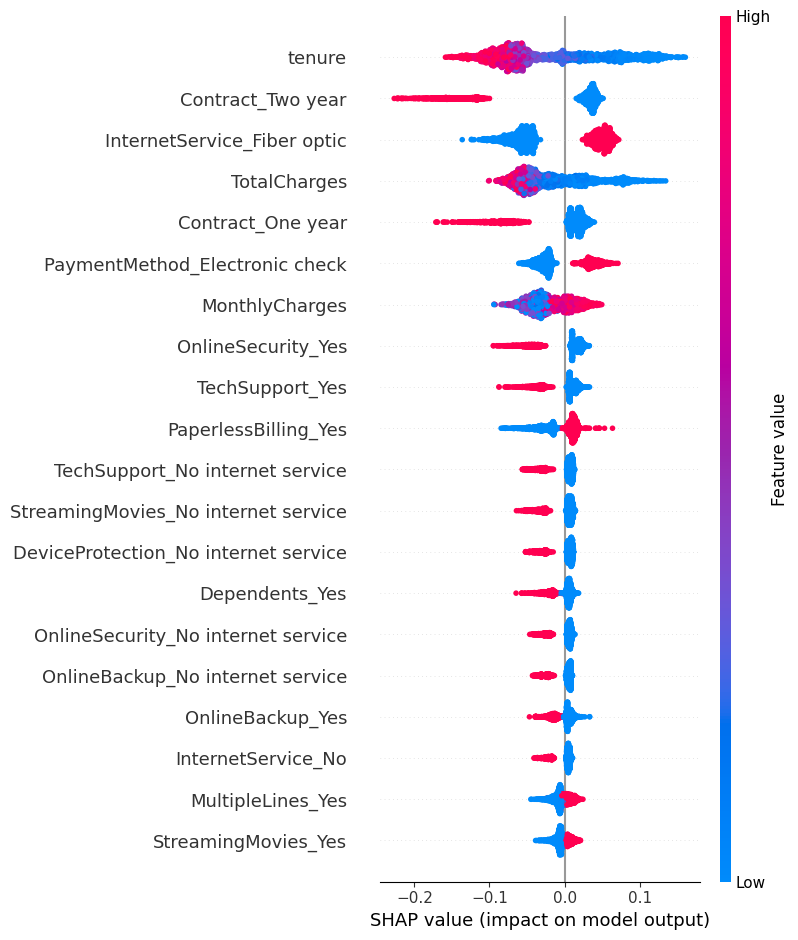

In [6]:
import shap

# 1. Transform the test data
X_test_transformed = pipeline.named_steps['preprocess'].transform(X_test)

# 2. Initialize Explainer
explainer = shap.TreeExplainer(pipeline.named_steps['rf'])
shap_results = explainer.shap_values(X_test_transformed)

# 3. Handle the shape mismatch logic
# If Random Forest returns a list [values_for_0, values_for_1]
if isinstance(shap_results, list):
    # We want the values for Class 1 (Churn)
    final_shap_values = shap_results[1]
else:
    # If it's a single 3D array [samples, features, classes]
    if len(shap_results.shape) == 3:
        final_shap_values = shap_results[:, :, 1]
    else:
        final_shap_values = shap_results

# 4. Plotting
plt.figure(figsize=(10, 6))
shap.summary_plot(final_shap_values, X_test_transformed, feature_names=feature_names)

3. Identify a High-Risk Customer

    First, let's find a customer from your test set that the model is very confident will churn.

In [8]:
# Get probabilities for the test set
test_probs = grid.predict_proba(X_test)[:, 1]

# Find the index of the customer with the highest churn probability
high_risk_idx = np.argmax(test_probs)
print(f"Customer Index: {high_risk_idx}")
print(f"Churn Probability: {test_probs[high_risk_idx]:.2%}")

Customer Index: 1675
Churn Probability: 95.35%


4. Force Plots by Risk Percentiles

    If you want to compare specific groups—for example, a "typical" low-risk customer vs. a "typical" high-risk customer—you can select samples based on their probability percentiles.

--- 10th Percentile (Low Risk) (Prob: 2.26%) ---


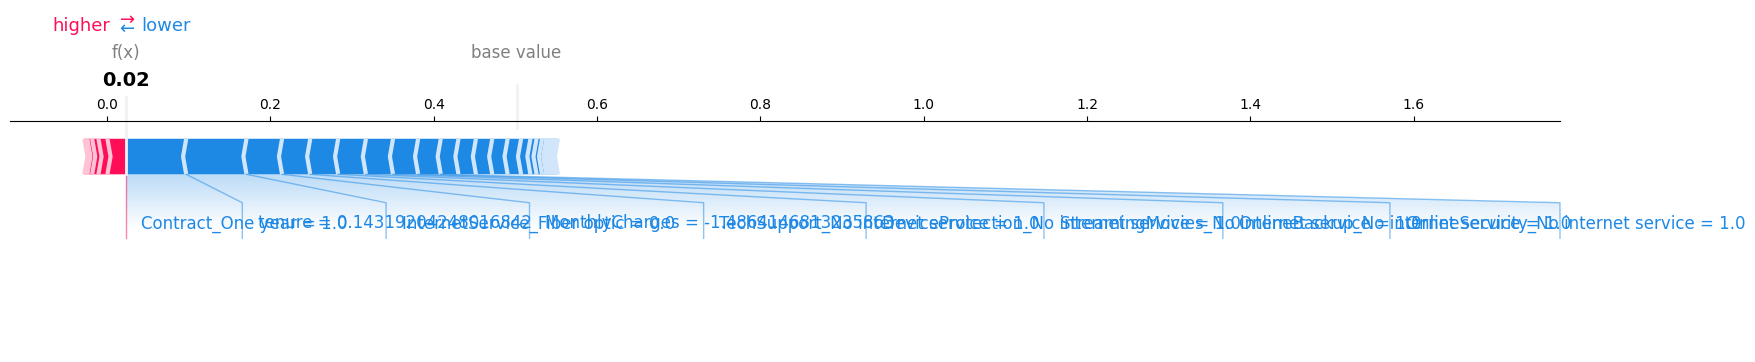

None

--- 50th Percentile (Median) (Prob: 31.21%) ---


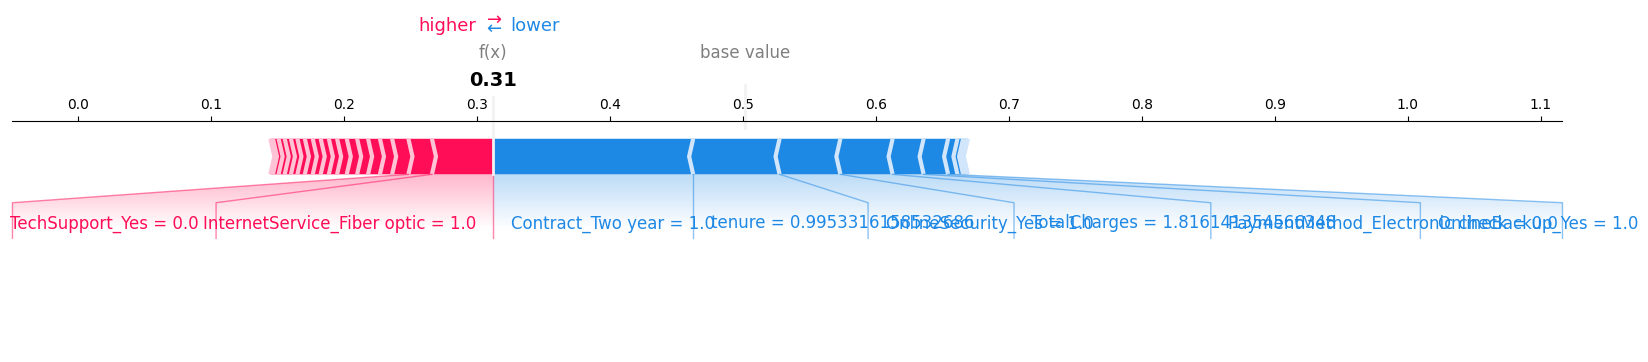

None

--- 90th Percentile (High Risk) (Prob: 78.94%) ---


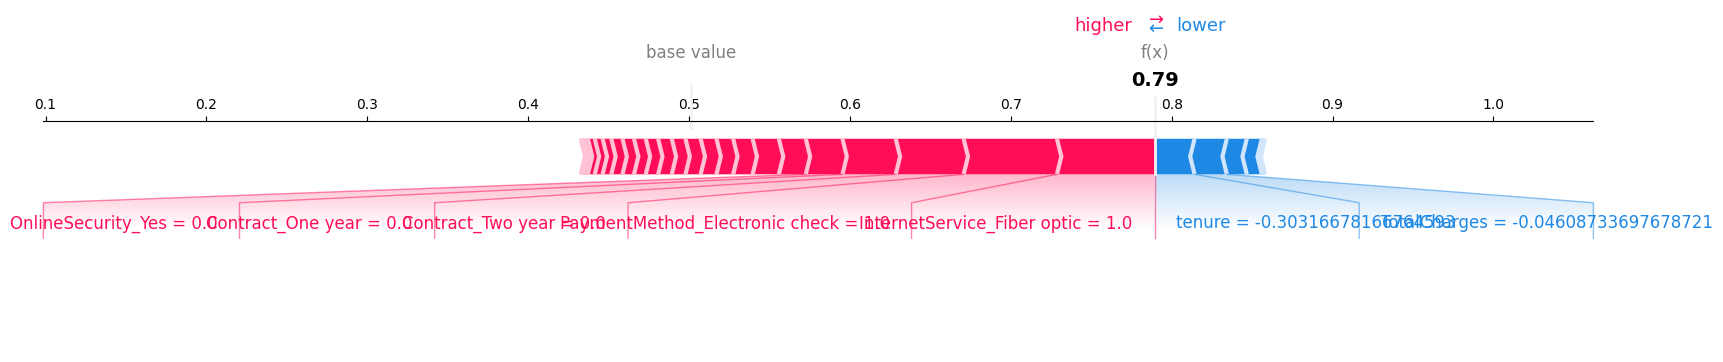

None

In [12]:
# 1. Calculate probabilities for all test samples
test_probs = grid.predict_proba(X_test)[:, 1]
probs_series = pd.Series(test_probs)

# 2. Identify indices for specific percentiles
indices = {
    "10th Percentile (Low Risk)": probs_series.nsmallest(int(len(probs_series)*0.1)).index[-1],
    "50th Percentile (Median)": probs_series.sub(probs_series.median()).abs().idxmin(),
    "90th Percentile (High Risk)": probs_series.nlargest(int(len(probs_series)*0.1)).index[-1]
}

# 3. Plot them sequentially
for label, idx in indices.items():
    print(f"--- {label} (Prob: {test_probs[idx]:.2%}) ---")
    display(shap.force_plot(
        explainer.expected_value[1], 
        final_shap_values[idx, :], 
        X_test_transformed[idx, :],
        feature_names=feature_names,
        matplotlib=True # Use matplotlib=True to render multiple plots in a loop
    ))

5. The "Decision Plot

    The Decision Plot is often better for showing "percentiles" or trajectories. Each line represents one customer, showing how their risk accumulates feature-by-feature.

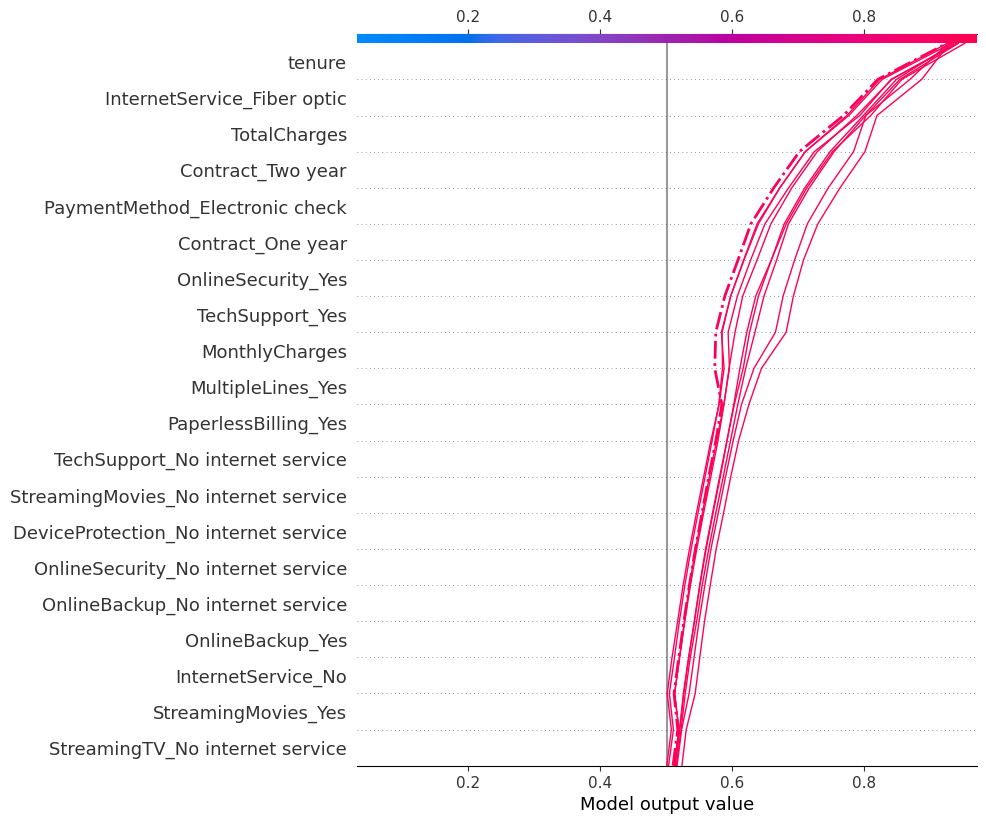

In [13]:
# Plotting the 10 highest-risk customers to see their common path to churn
top_10_idx = np.argsort(test_probs)[-10:]

shap.decision_plot(
    explainer.expected_value[1], 
    final_shap_values[top_10_idx], 
    feature_names=feature_names,
    highlight=0 # Highlights the very highest risk individual
)

### How to read this for a Business Stakeholder:

The Output Value: The bold number in the center is the model's score for this customer. If it's higher than the "base value," they are at high risk.

The "Push" (Red): These are the reasons the customer is leaving. For example, if Contract_Month-to-month is a large red block, that is your primary target for intervention (e.g., offer them a discount to switch to a 1-year plan).

The "Pull" (Blue): These are the factors keeping them around. If Tenure is blue, it means their long-term history with the company is currently preventing them from churning even faster

In [10]:
# Get SHAP values for this specific customer
cust_shap = pd.Series(final_shap_values[high_risk_idx], index=feature_names)

# Get top 3 features pushing them towards Churn
top_churn_drivers = cust_shap.sort_values(ascending=False).head(3)

print(f"Top 3 reasons this customer is at risk:")
for feature, impact in top_churn_drivers.items():
    print(f"- {feature} (Impact score: {impact:.4f})")

Top 3 reasons this customer is at risk:
- tenure (Impact score: 0.0954)
- TotalCharges (Impact score: 0.0580)
- InternetService_Fiber optic (Impact score: 0.0472)


This allows you to not only tell a manager who will churn, but exactly what the customer success agent should talk about when they call that custome

## Conclusion

By integrating a Random Forest pipeline with SHAP explainability, we have moved beyond simple "black box" predictions to a transparent, actionable retention strategy. The model demonstrates high reliability (ROC AUC ≈ 0.82), but the real value lies in the personalized churn stories revealed by the force plots. We now know that while Tenure and Total Charges set the baseline risk, the "tipping point" for high-risk customers is almost always driven by Month-to-Month contracts and Electronic Check payments.

Moving forward, the business should transition from broad marketing to targeted interventions:

- High-Risk Personas: Use the 90th percentile SHAP profiles to identify customers who should receive immediate "loyalty switch" offers (e.g., migrating from monthly to annual plans).

- Feature-Based Mitigation: Since high monthly charges are a primary churn driver, implementing automated "Value-Added" notifications for high-spend customers could improve perceived worth.

- Operational Shift: By deploying these SHAP values directly into a CRM, customer success teams can see exactly which "Red" factors to address during a save-call, turning data science into a direct tool for revenue protection.